<a href="https://colab.research.google.com/github/josephpushnam/capstone/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
install.packages("ggplot2")
install.packages("dplyr")
install.packages("lubridate")
install.packages("car")
install.packages("forecast")
install.packages("tseries")

# Load libraries
library(ggplot2)
library(dplyr)
library(lubridate)
library(car)
library(forecast)
library(tseries)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



This is a continuation of the analysis of GDP data from the example homework assignment

In [ ]:
# Load the CSV data
gdp_data <- read.csv('/content/GDPC1.csv')

In [ ]:
# Convert the DATE column to Date type
gdp_data$DATE <- as.Date(gdp_data$DATE)

# Filter data for the time frame 2009-2024
gdp_filtered <- gdp_data %>%
  filter(DATE >= as.Date("2009-01-01") & DATE <= as.Date("2024-12-31"))

In [ ]:
# Dummy variable for pandemic 01/2020-01/2022
gdp_filtered$pandemic <- ifelse(gdp_filtered$DATE >= as.Date("2020-01-01") & gdp_filtered$DATE <= as.Date("2022-01-01"), 1, 0)

# Create a dummy variable for presidential terms
gdp_filtered$president <- case_when(
  gdp_filtered$DATE >= as.Date("2009-01-01") & gdp_filtered$DATE < as.Date("2017-01-01") ~ "Obama",
  gdp_filtered$DATE >= as.Date("2017-01-01") & gdp_filtered$DATE < as.Date("2021-01-01") ~ "Trump",
  gdp_filtered$DATE >= as.Date("2021-01-01") ~ "Biden")

#Create GDP percent
gdp_filtered <- gdp_filtered %>%
  arrange(DATE) %>%
  mutate(gdp_pct_change = (GDPC1 - lag(GDPC1)) / lag(GDPC1) * 100)

# Remove NA values caused by the lag function
gdp_filtered <- gdp_filtered %>%
  filter(!is.na(gdp_pct_change))

# Run the OLS regression
model <- lm(gdp_pct_change ~ as.numeric(DATE) + pandemic + president, data = gdp_filtered)

# View the summary of the regression
summary(model)


Call:
lm(formula = gdp_pct_change ~ as.numeric(DATE) + pandemic + president, 
    data = gdp_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2727 -0.2234  0.0340  0.3067  7.4684 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)
(Intercept)       1.256e+00  6.021e+00   0.209    0.836
as.numeric(DATE) -2.051e-05  3.124e-04  -0.066    0.948
pandemic         -1.677e-01  6.317e-01  -0.266    0.792
presidentObama   -3.852e-01  1.228e+00  -0.314    0.755
presidentTrump   -3.479e-01  7.205e-01  -0.483    0.631

Residual standard error: 1.575 on 56 degrees of freedom
Multiple R-squared:  0.007126,	Adjusted R-squared:  -0.06379 
F-statistic: 0.1005 on 4 and 56 DF,  p-value: 0.9819


In [ ]:
# Durbin-Watson Test for autocorrelation
durbinWatsonTest(model)

 lag Autocorrelation D-W Statistic p-value
   1      -0.2960281      2.587861   0.054
 Alternative hypothesis: rho != 0

Autocorrelation exists making this dataset suitable for ARIMA

In [ ]:
# Perform the Augmented Dickey-Fuller test on GDP percent change
adf_test_result <- adf.test(gdp_filtered$gdp_pct_change)

# Print the result
print(adf_test_result)

Warning message in adf.test(gdp_filtered$gdp_pct_change):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  gdp_filtered$gdp_pct_change
Dickey-Fuller = -5.4256, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary



Dickey-Fuller test indicates data is stationary with no need to create a difference score. d = 0

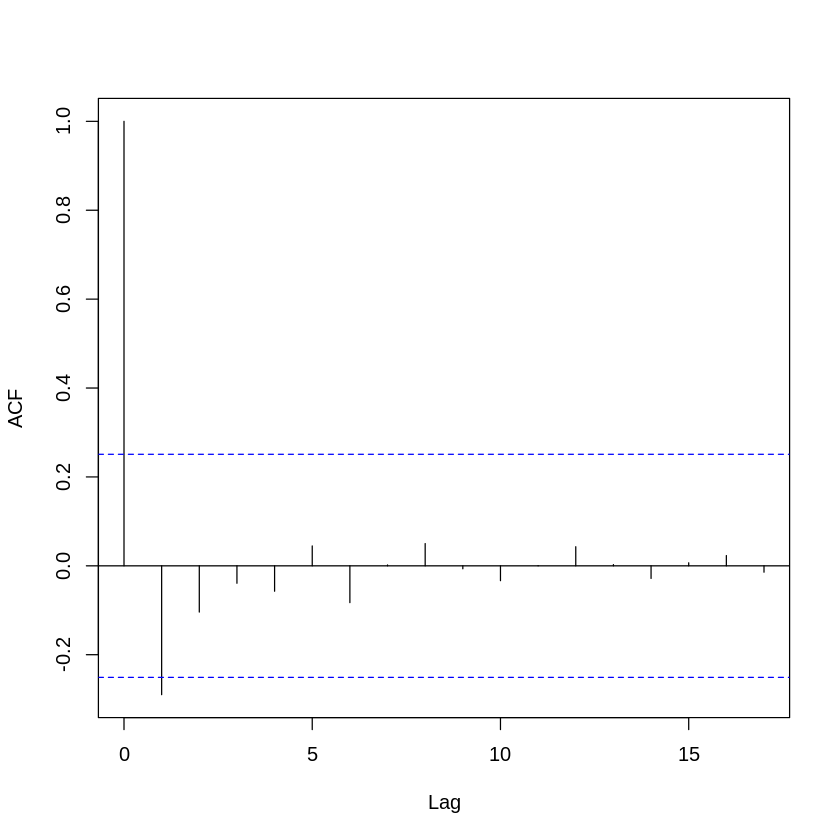

In [ ]:
acf((gdp_filtered$gdp_pct_change), main='')

The ACF plot indicates that 1 prior period influences the current data so q=1.

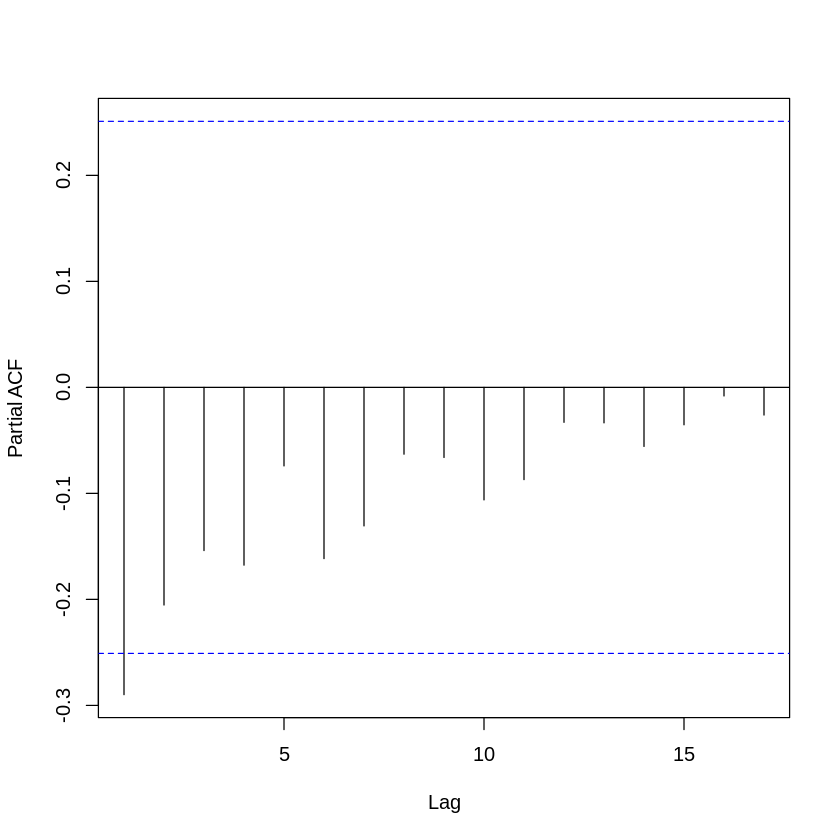

In [ ]:
pacf((gdp_filtered$gdp_pct_change), main='')

This pacf doesn't show 0 so the first is the first prior month with no other significant periods so p = 1.

In [ ]:
# Run Manual ARIMA
xreg <- model.matrix(~ pandemic + president, data = gdp_filtered)[, -1]

manual_ARIMA<- arima(gdp_filtered$gdp_pct_change, order=c(1,0,1), xreg = xreg)
summary(manual_ARIMA)


Call:
arima(x = gdp_filtered$gdp_pct_change, order = c(1, 0, 1), xreg = xreg)

Coefficients:
         ar1      ma1  intercept  pandemic  presidentObama  presidentTrump
      0.3038  -1.0000     0.7881    0.0210         -0.2066         -0.2809
s.e.  0.1239   0.0438     0.1335    0.2031          0.1392          0.1313

sigma^2 estimated as 1.473:  log likelihood = -100.12,  aic = 214.24

Training set error measures:
                      ME     RMSE       MAE      MPE     MAPE      MASE
Training set -0.04062762 1.213559 0.5481605 65.43059 144.7187 0.5779598
                   ACF1
Training set 0.01460581

The manual ARIMA outperformed the auto ARIMA (AIC 214 vs 228) so I'll stick with manual.

In [ ]:
# Run auto-ARIMA
xreg <- model.matrix(~ pandemic + president, data = gdp_filtered)[, -1]

arima_model <- auto.arima(gdp_filtered$gdp_pct_change, xreg = xreg)
summary(arima_model)

Series: gdp_filtered$gdp_pct_change 
Regression with ARIMA(2,0,0) errors 

Coefficients:
          ar1      ar2  intercept  pandemic  presidentObama  presidentTrump
      -0.3633  -0.2337     0.8397    0.0406         -0.2812         -0.3902
s.e.   0.1239   0.1243     0.2803    0.3810          0.3231          0.3386

sigma^2 = 2.175:  log likelihood = -107.19
AIC=228.39   AICc=230.5   BIC=243.16

Training set error measures:
                       ME     RMSE       MAE      MPE     MAPE      MASE
Training set -0.006139473 1.400275 0.6650594 51.25551 159.2149 0.7012135
                    ACF1
Training set -0.04708633

In [ ]:
# Extract the coefficients and standard errors
coefs <- coef(manual_ARIMA)
se <- sqrt(diag(vcov(manual_ARIMA)))

# Calculate z-statistics
z_values <- coefs / se

# Calculate p-values (two-tailed test)
p_values <- 2 * pnorm(abs(z_values), lower.tail = FALSE)

# Combine coefficients, standard errors, z-values, and p-values into a data frame
results <- data.frame(Coefficient = coefs, `Standard Error` = se, `Z-value` = z_values, `P-value` = p_values)

# Print results
print(results)

               Coefficient Standard.Error     Z.value       P.value
ar1             0.30379209     0.12391605   2.4515961  1.422242e-02
ma1            -0.99999948     0.04381609 -22.8226535 2.732109e-115
intercept       0.78805906     0.13349404   5.9033278  3.562414e-09
pandemic        0.02098142     0.20313542   0.1032878  9.177345e-01
presidentObama -0.20655168     0.13922501  -1.4835817  1.379199e-01
presidentTrump -0.28089817     0.13132824  -2.1389015  3.244365e-02


The % GDP change is now significant in model with Trump significantly less than Biden (standard error * 2 is also less than coefficient in model).


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with non-zero mean
Q* = 3.3352, df = 8, p-value = 0.9116

Model df: 2.   Total lags used: 10



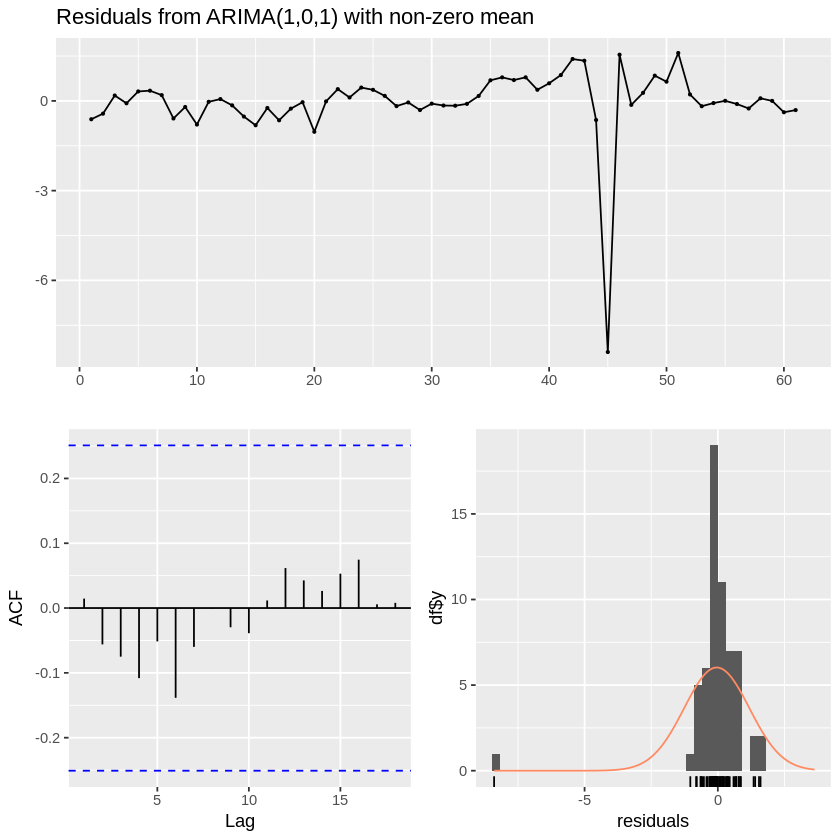

In [ ]:
checkresiduals(manual_ARIMA)

The p value on the test is high indicating that we have taken care of the auto-correlation and there is no lingering in the residuals.

In [ ]:
# Calculate the residuals for ARIMA model
arima_resid <- residuals(manual_ARIMA)

# Pseudo R-squared
pseudo_r_squared_arima <- 1 - var(arima_resid) / var(gdp_filtered$gdp_pct_change)

cat("ARIMA Pseudo R-squared", pseudo_r_squared_arima, "\n")
cat("OLS R-squared", summary(model)$r.squared)

ARIMA Pseudo R-squared 0.3583024 
OLS R-squared 0.007125753

In [ ]:
# Residuals from the ARIMA model
arima_resid <- residuals(manual_ARIMA)

# Total variance of the original time series
total_variance <- var(gdp_filtered$gdp_pct_change)

# Residual variance of the ARIMA model
residual_variance <- var(arima_resid)

# Number of observations
n <- length(gdp_filtered$gdp_pct_change)

# Number of parameters in the ARIMA model (p = AR + MA + differencing terms)
p <- length(manual_ARIMA$coef) + manual_ARIMA$arma[6]

# Adjusted Pseudo R-squared
adjusted_pseudo_r_squared <- 1 - (residual_variance / total_variance) * (n - 1) / (n - p - 1)

# Print the result
cat("ARIMA Adjusted Pseudo R-squared:", adjusted_pseudo_r_squared, "\n")
cat("OLS Adjusted R-squared", summary(model)$adj.r.squared)

ARIMA Adjusted Pseudo R-squared: 0.2870026 
OLS Adjusted R-squared -0.06379384

In [ ]:
# AIC for ARIMA model
AIC_arima <- AIC(manual_ARIMA)

# AIC for OLS model
AIC_ols <- AIC(model)

# Compare AIC values
cat("ARIMA AIC", AIC_arima, "\n")
cat("OLS AIC", AIC_ols)

ARIMA AIC 214.2382 
OLS AIC 235.2818

In [ ]:
# For ARIMA model: Forecast on the same data
arima_fitted <- fitted(manual_ARIMA)

# For OLS model: Get the fitted values
ols_fitted <- fitted(model)

# Calculate RMSE for ARIMA
rmse_arima <- sqrt(mean((gdp_filtered$gdp_pct_change - arima_fitted)^2))

# Calculate RMSE for OLS
rmse_ols <- sqrt(mean((gdp_filtered$gdp_pct_change - ols_fitted)^2))

# Compare RMSE
rmse_arima
rmse_ols

[1] 1.213559

[1] 1.508688

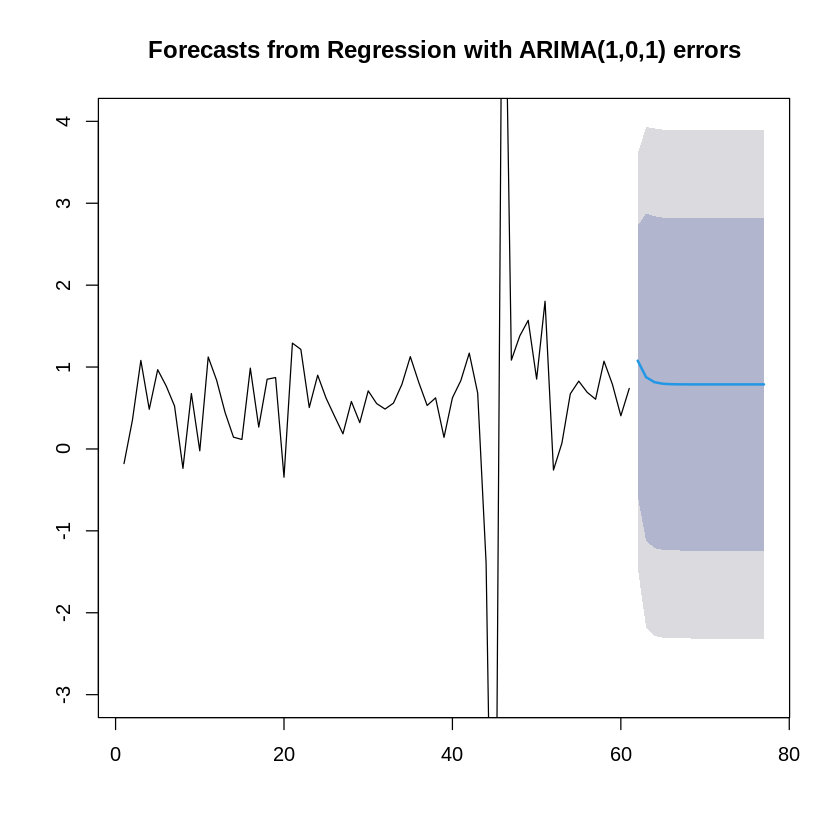

In [ ]:
# External regressors (e.g., pandemic and president dummy variables)
xreg <- model.matrix(~ pandemic + president, data = gdp_filtered)[, -1]

# Fit ARIMAX model (assuming the order is determined)
arimax_model <- Arima(gdp_filtered$gdp_pct_change, order = c(1,0,1), xreg = xreg)

# Forecast future values
forecast_horizon <- 16

pandemic <- rep(0, forecast_horizon)
presidentObama <- rep(0, forecast_horizon)
presidentTrump <- rep(0, forecast_horizon)

# Create the future_xreg matrix
future_xreg <- cbind(pandemic, presidentObama, presidentTrump)

# Forecast with external regressors
arimax_forecast <- forecast(arimax_model, xreg = future_xreg, h = forecast_horizon)

# Plot the forecast with confidence intervals
plot(arimax_forecast, ylim = c(-3, 4))

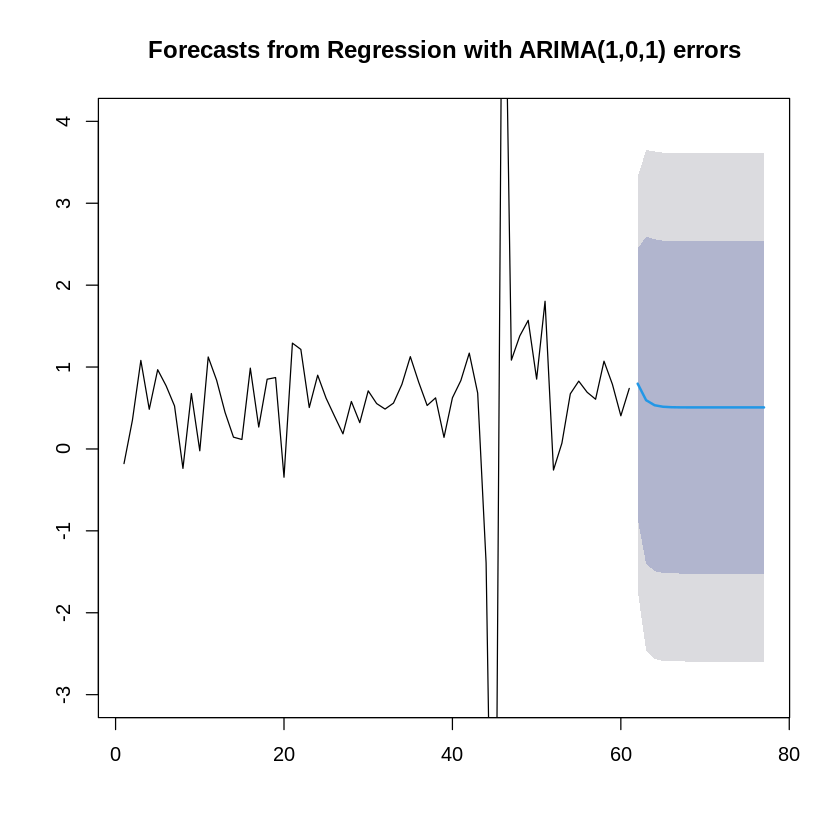

In [ ]:
# External regressors (e.g., pandemic and president dummy variables)
xreg <- model.matrix(~ pandemic + president, data = gdp_filtered)[, -1]

# Fit ARIMAX model (assuming the order is determined)
arimax_model <- Arima(gdp_filtered$gdp_pct_change, order = c(1,0,1), xreg = xreg)

# Forecast future values
forecast_horizon <- 16

pandemic <- rep(0, forecast_horizon)
presidentObama <- rep(0, forecast_horizon)
presidentTrump <- rep(1, forecast_horizon)

# Create the future_xreg matrix
future_xreg <- cbind(pandemic, presidentObama, presidentTrump)

# Forecast with external regressors
arimax_forecast <- forecast(arimax_model, xreg = future_xreg, h = forecast_horizon)

# Plot the forecast with confidence intervals
plot(arimax_forecast, ylim = c(-3, 4))